In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks

In [15]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','rev','rev_fp_in_clust')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [16]:
task_name_dict = {}
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]

In [17]:
def plot_epoch_labels(ax, epoch_binary, which_axes = 'y', ms = .9):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')

    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        where = np.where(epoch_binary[e_name])[0]-.7
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)

            for w in where:
            
                rect = patches.Rectangle((w, yl), 1, 3,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)
            
            for w in where:
                rect = patches.Rectangle((xl, w), 3, 1,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
            
def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())+2
        xl = np.max(ax.get_xlim())+2

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
        

In [18]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/'
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))

feature_names_master = cluster_var['tick_names']


In [19]:
#MAKE COR MATS
# set of networks to compare
import matplotlib.patches as patches
rnn_type_set = ['LeakyGRU','LeakyRNN']
activation_set = ['tanh','retanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1', ]

In [20]:
color_set = {}
color_set['tanh'] = 'k'
color_set['retanh'] = 'dodgerblue'
color_set['softplus'] = 'orangered'
activation_set = ['tanh','retanh','softplus']

In [21]:
def make_cluster_midpoint_labels(clust):
    d = np.concatenate(([-1], np.where(np.diff(clust))[0],[len(clust)-1]),axis = 0)
    mid = np.zeros(len(d))
    cluster_size = np.zeros(len(d))
    for xi in range(len(d)-1):
        cluster_size[xi] = d[xi+1] - d[xi]
        mid[xi] = d[xi+1]-cluster_size[xi]/2+.5
    return cluster_size, mid

In [22]:
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
            15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z',
           27:'a', 28:'b', 29:'c', 30:'d', 31:'e', 32:'f', 33:'g', 34:'h', 35:'i', 36:'j', 37:'k', 38:'l', 39:'m', 
            40:'n', 41:'o', 42:'p', 43:'q', 44:'r', 45:'s', 46:'t', 47:'u', 48:'v', 49:'w', 50:'x', 51:'y', 52:'z'}


In [23]:
# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU']
activation_set = ['softplus','tanh','retanh']
w_init_set = ['diag','randgauss']

seed_set = [str(0),str(1),]
max_d = 3.5
n_rnn = str(128)
x_ind_counter = 0
ax1_xticks = []
method = 'ward'
all_epochs = ['stim1','stim2','delay1','delay2','go1']

In [24]:
def get_filename_fp(trial, epoch,t):
    ind_stim_loc  = 180*trial.y_loc[-1,t]/np.pi
    filename = epoch+'_'+str(round(ind_stim_loc,2))+'.npz'

    return filename, ind_stim_loc

def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

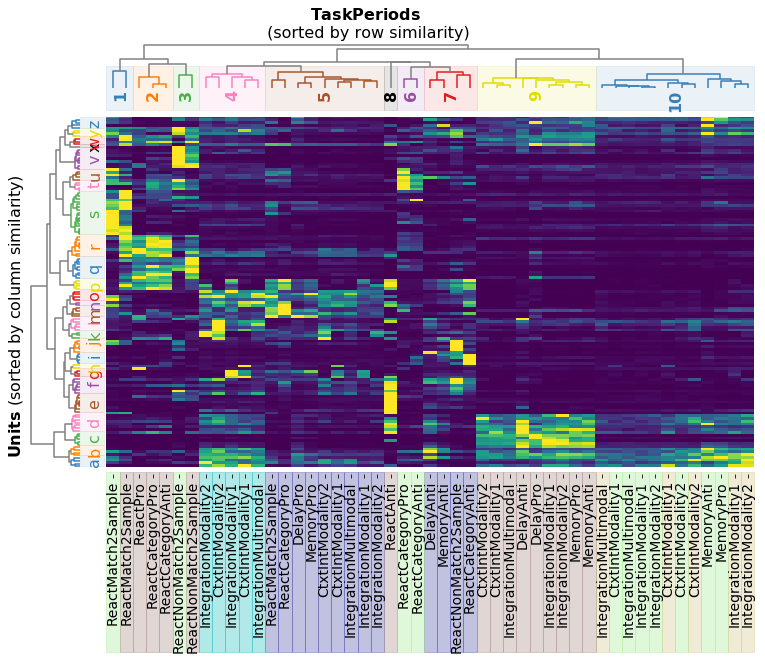

In [25]:
### load master network and make average correlation matrix across seeds

x_ind_counter = 0
ax1_xticks = []

import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
criterion = 'distance'
cel_max_d = '3.5'

m_master = m
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]

#visualize atlas for master network
fig = plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .55
atlas_height = .55
thresh = 4

axdendro_top = fig.add_axes([.06,atlas_height+.09,atlas_width-.05,.07])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion=criterion)
Z_top = sch.dendrogram(Y, orientation='top',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)
#                     plt.text(-96,-18,'Task Period \n Cluster #')

cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
for xi in range(len(mid_top)-1):
    if cluster_size[xi]==1:
        c = 'k'
    else:
        color_ind = xi - np.sum(cluster_size[:xi]==1)
        c = color_palette[color_ind%len(color_palette)]
    clust_mid = mid_top[xi]
    rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10, 
    fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(clust_mid*10,-3,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)
#                         plt.text(xi*10,-15,str(clusters_sorted[int(xi)]))

remove_spines(axdendro_top)
remove_ticks(axdendro_top)
axdendro_top.set_xticks([])

axdendro = fig.add_axes([0,.054,0.04,atlas_height*.98])
Y = sch.linkage(X, method=method)
clusters = fcluster(Y, max_d, criterion=criterion)

Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=2.07,
                          above_threshold_color='gray', labels = clusters)

clusters = cluster_var['clusters']
#                     Z = cluster_var['Z']

cluster_size, mid = make_cluster_midpoint_labels(clusters)
for xi in range(len(mid)-1):

    if xi>22:
        ci = xi-1
    else:
        ci = xi

    c = color_palette[ci%len(color_palette)]

    if xi==22:
        c = 'k'

    clust_mid = mid[xi]
    rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(-1.5,10*clust_mid-20,alphabet[clusters[int(clust_mid)]],color =c,rotation = 90)

remove_spines(axdendro)
remove_ticks(axdendro)
axdendro.set_xticks([])


axmatrix = fig.add_axes([.06,0.045,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')

len_te = len(feature_names_labels)
axmatrix.set_xticks(range(len_te))
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
#                     plot_epoch_labels(axmatrix,epoch_binary,which_axes = 'y',ms = 12.5)
plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 65)
#                     plt.legend(bbox_to_anchor=(1.1, -.13),ncol=2,fontsize = 14,rotation = 90)    

plt.text(-8,len(X)/5,r"$\bf{Units}$"+' (sorted by column similarity)',rotation = 90)
# plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master.split()),rotation = 90)
axmatrix.set_xlabel(r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
axmatrix.xaxis.set_label_coords(.4, 1.31)
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((len(X)+1,0))

# make subpanels.
sp_width = .14
sp_wide = .2
offset = .06

plt.show()

Choosing 2 clusters


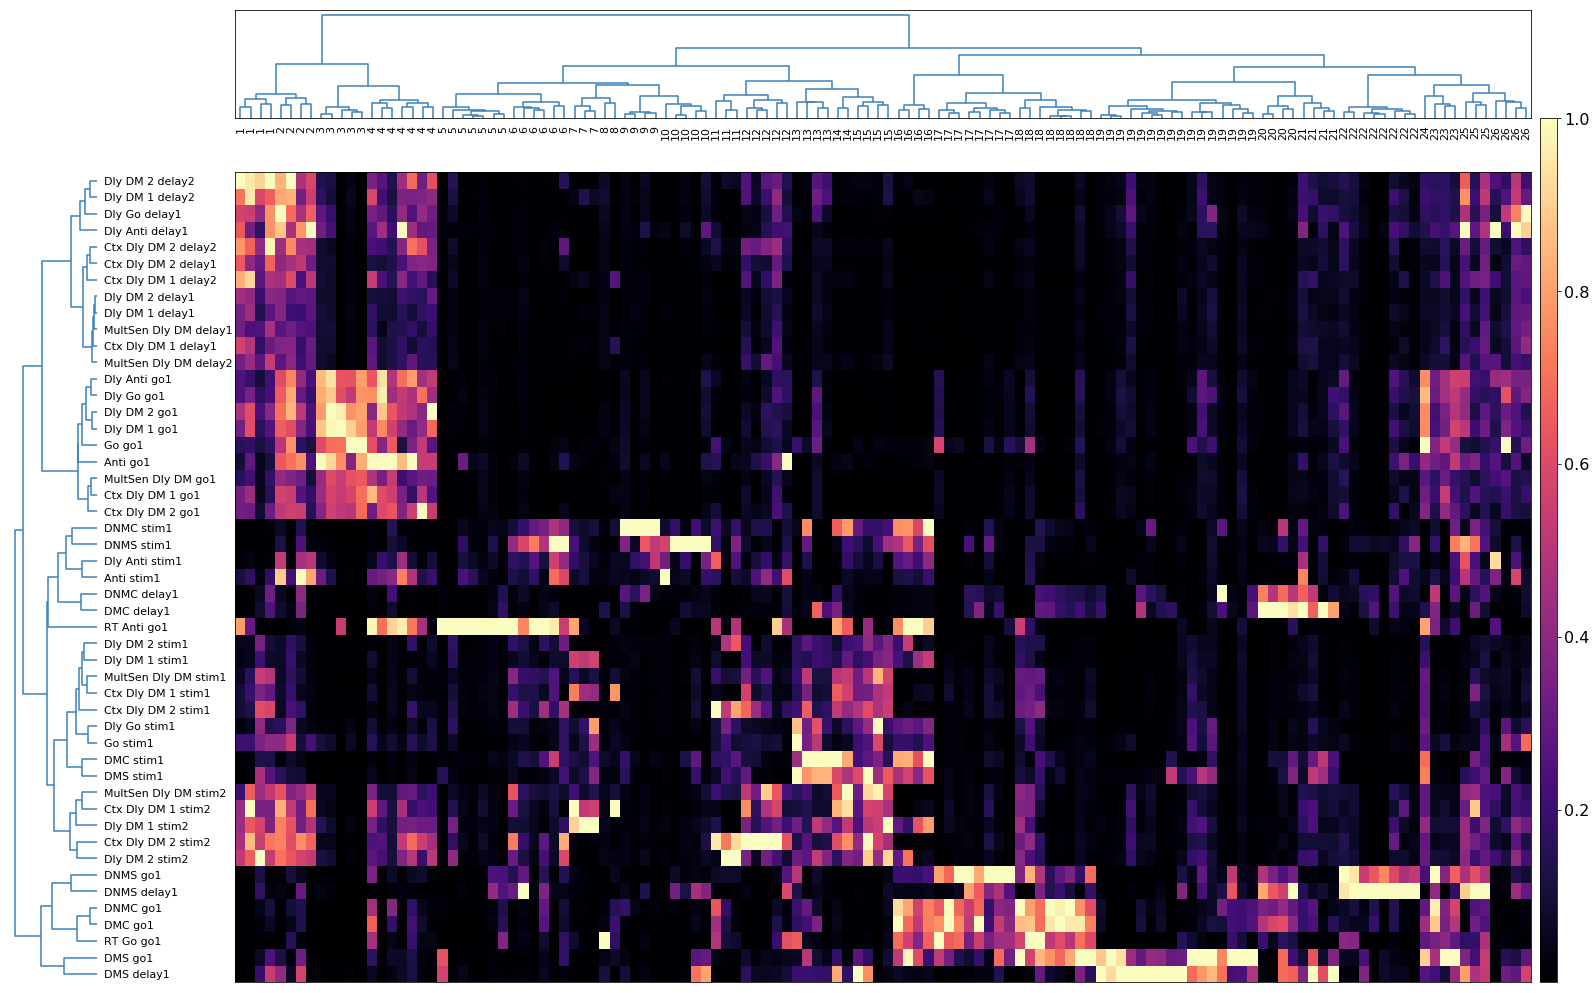

In [26]:
from tools_lnd import make_dendro
make_dendro(m,method = 'ward',criterion = 'maxclust',cel_max_d = 0,max_d = 0,normalization_method = 'max')

Choosing 2 clusters


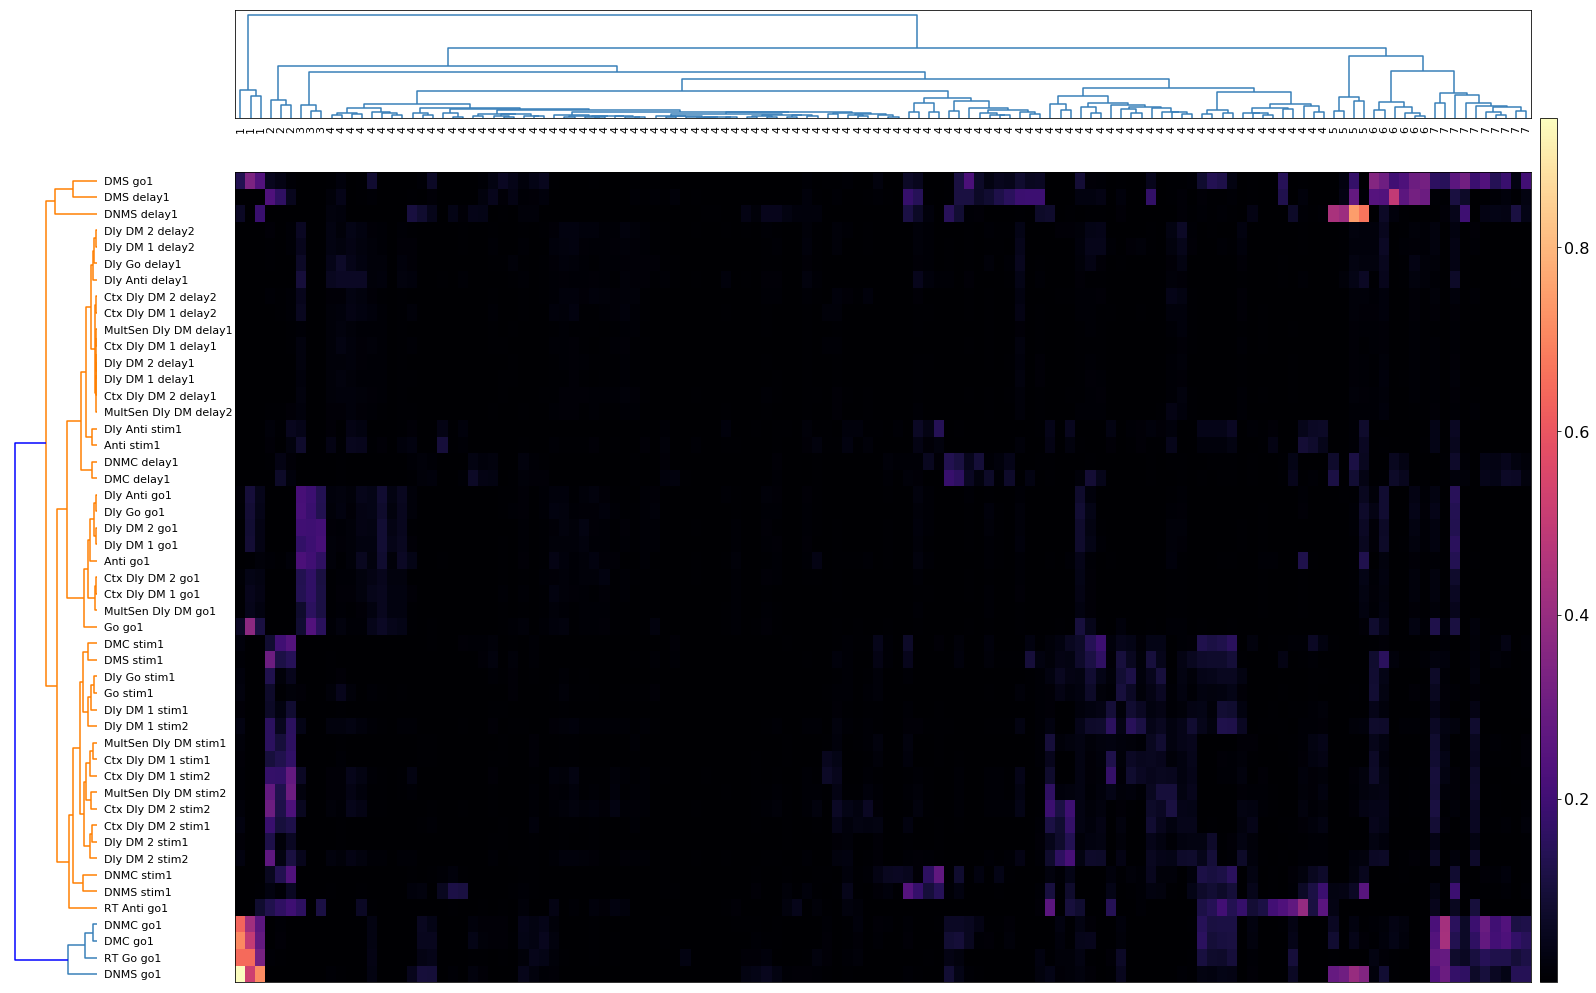

In [27]:
from tools_lnd import make_dendro
make_dendro(m,method = 'ward',criterion = 'maxclust',cel_max_d = 0,max_d = 0,normalization_method = 'none')

Choosing 6 clusters


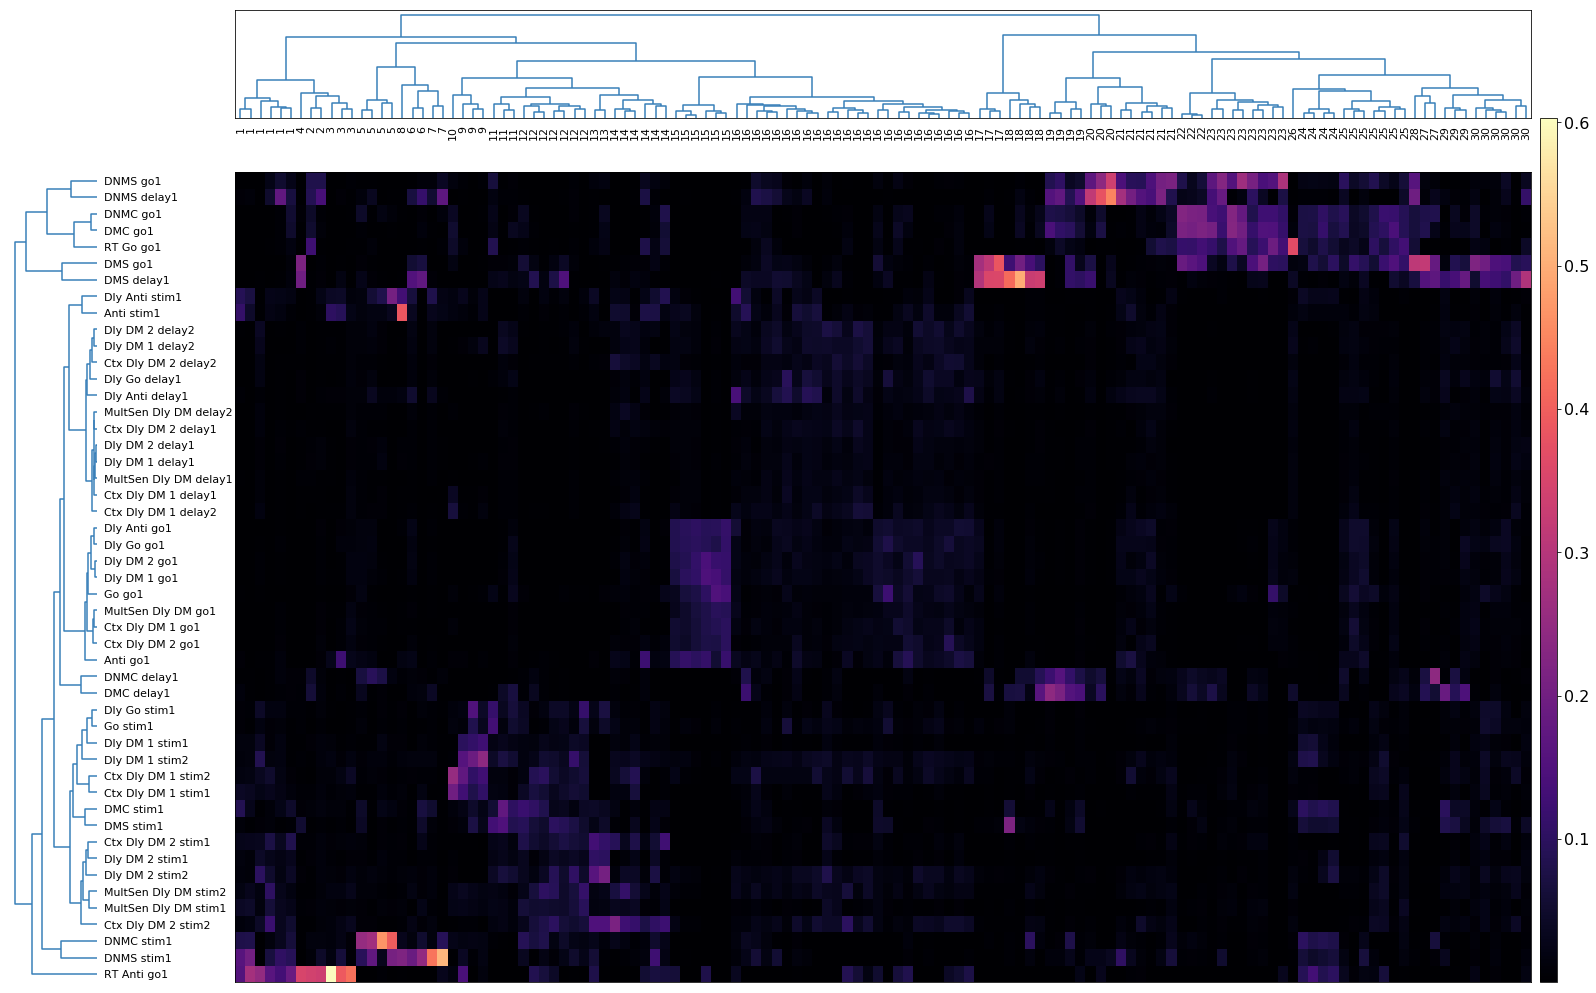

In [28]:
from tools_lnd import make_dendro
make_dendro(m,method = 'ward',criterion = 'maxclust',cel_max_d = 0,max_d = 0,normalization_method = 'sum')

In [119]:
from collections import OrderedDict
from task import generate_trials
import tools

h_all_byepoch = OrderedDict()
h_all_byrule = OrderedDict()

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    
    hp = model.hp

    rules = hp['rules']
    print(rules)

    n_hidden = hp['n_rnn']

    for rule in rules:
        trial = generate_trials(rule, hp, 'test', noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hp)
        h = sess.run(model.h, feed_dict=feed_dict)

        for e_name, e_time in trial.epochs.items():
            if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1], :, :]
                
                        # Ignore fixation period
        h_all_byrule[rule] = h

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
[u'fdgo', u'reactgo', u'delaygo', u'fdanti', u'reactanti', u'delay

In [33]:
#CAT TASKS
interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

axs = 'pca_h_cat'

rule_set = [13,14]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

epoch_set = ['delay1','delay1']
rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule_str, epoch_set, axs = axs)

D_use = D_stim

keep_units = []
[keep_units.append(x) for x in cluster_var['lesion_units_list'][5]]#a
# [keep_units.append(x) for x in cluster_var['lesion_units_list'][2]]#b
print(keep_units)

D_lesion = np.zeros(np.shape(D_stim))
for x in keep_units:
    D_lesion[x,:] = D_stim[x,:] 
    
D_use = D_lesion

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' State PC1',
             epoch_name_ax+' State PC2',
             epoch_name_ax+' State PC3']

script_name = 'interp_tasks_small_init_mov'

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
         fig_size = 7, color_stim = True, figpath = figpath, cmap_discrete = ['w','k'], fp_first = False, axs = axs)  

NameError: name 'rules_dict' is not defined

In [ ]:
h_all = {}
h_all = {'by_epoch': h_all_byepoch,
        'by_rule': h_all_byrule}

np.savez(os.path.join(m,'h_all.npz'),**h_all)

In [ ]:
epoch = 'stim1'

for x in range(1,3):
    
    for task in ['fdanti','delayanti']:

        plt.plot(h_all_byepoch[(task, epoch)][-1,:,:], c = 'gray',alpha = .5)

        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][1]].T,c = 'b',linewidth = 2)
        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][2]].T,c = 'g',linewidth = 2)
        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][3]].T,c = 'c',linewidth = 2)

        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][26]].T,c = 'r',linewidth = 1)
        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][25]].T,c = 'r',linewidth = 1)
        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][24]].T,c = 'r',linewidth = 1)
        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][23]].T,c = 'r',linewidth = 1)


#         plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][12]].T,c = 'm',linewidth = 1)
#         plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][13]].T,c = 'm',linewidth = 1)


        plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][x]].T,c = 'm',linewidth = 1)


        plt.title(alphabet[x])
    plt.show()

In [ ]:
task = 'dmcnogo'
epoch = 'stim1'

plt.plot(h_all_byepoch[(task, epoch)][-1,:,:], c = 'gray',alpha = .5)

plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][1]].T,c = 'b',linewidth = 2)
plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][2]].T,c = 'g',linewidth = 2)
plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][3]].T,c = 'c',linewidth = 2)
plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][10]].T,c = 'k',linewidth = 2)

plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][6]].T,c = 'r',linewidth = 1)
# plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][25]].T,c = 'r',linewidth = 1)
# plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][24]].T,c = 'r',linewidth = 1)
# plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][23]].T,c = 'r',linewidth = 1)


# plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][12]].T,c = 'm',linewidth = 1)
# plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][24]].T,c = 'm',linewidth = 1)

plt.show()

In [ ]:
task = 'delayanti'
epoch = 'go1'

In [ ]:
np.shape(h_all_byepoch[(task, epoch)])

In [ ]:
for x in range(1,27):
    plt.plot(h_all_byepoch[(task, epoch)][-1,:,:], c = 'gray',alpha = .5)

    plt.plot(h_all_byepoch[(task, epoch)][-1,:,cluster_var['lesion_units_list'][x]].T,c = 'b',linewidth = 2)

    plt.title(alphabet[x])
    plt.show()

In [ ]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

In [ ]:
epoch = 'stim1'

In [ ]:
e_start = max([0, trial.epochs[epoch][0]])
end_set = [n_steps, trial.epochs[epoch][1]]
e_end = min(x for x in end_set if x is not None)

In [ ]:
def add_unique_to_inputs_list(dict_list, key, value):
    for d in range(len(dict_list)):
        if (dict_list.values()[d]==value).all():
            return False, dict_list

    dict_list.update({key : value})
    return True, dict_list

In [ ]:
n_inputs = 0
input_set = {str(n_inputs) : np.zeros((1,n_input_dim))}

inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
n_steps, n_trials, n_input_dim = np.shape(trial.x[:,inds_use,:])

for t_ind in range(0,int(n_trials),int(n_trials/16)):

    t = inds_use[t_ind]
    inputs = np.squeeze(trial.x[e_start,t,:])
    inputs = inputs[np.newaxis,:]
    inputs_big = inputs[np.newaxis,:]

    unique_input, input_set = add_unique_to_inputs_list(input_set, str(n_inputs), inputs)

In [47]:
from tools_lnd import same_mov_inds, get_interp_filename, take_names, find_closest_fp_loc
from tools_lnd import gen_trials_from_model_dir, make_D_use, interp3d, get_model_params
from task import rules_dict

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1','delaydm2','contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

epoch = 'go1'
fp_epoch = epoch
q_thresh = 1e-6
axs = 'pca_h'

sorted_fps_dict =  {}

for rule in rule_trains:
    
    if (epoch == 'stim1') & (rule[:5] == 'react'):
        epoch_use = 'go1'
    else:
        epoch_use = epoch
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    n_steps, n_trials, n_input_dim = np.shape(trial.x[:,inds_use,:])

    cat_sorted_fps = []
    
    for ti in range(0,int(n_trials),int(n_trials/16)):#trial number
        
        if any(trial.x[trial.epochs[epoch][0]+1,0,:] - trial.x[trial.epochs[epoch][0]+1,1,:])!=0 :
            filename,_ = get_filename(trial,epoch_use,inds_use[ti])
        else: 
            filename,_ = get_filename(trial,epoch_use,inds_use[0])
            
        f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',rule,filename+'.npz')
        fp_struct = np.load(f)

        if epoch_use=='stim1':
            fp_use = np.where(fp_struct['qstar']<q_thresh/20)[0] 
        elif epoch_use=='delay1':
            fp_use = np.where(fp_struct['qstar']<100*q_thresh)[0] 
        else:
            fp_use = np.where(fp_struct['qstar']<1000*q_thresh)[0] 

        h_end = h_all_byepoch[(rule,epoch_use)][-1,ti,:]
        _, closest_fp_loc = find_closest_fp_loc(h_end,fp_struct['xstar'][fp_use,:])

        if len(cat_sorted_fps)==0:
            cat_sorted_fps = closest_fp_loc[np.newaxis,:]
        else:
            cat_sorted_fps = np.concatenate((cat_sorted_fps, closest_fp_loc[np.newaxis,:]))
            
    sorted_fps_dict[rule] = cat_sorted_fps
    

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

In [48]:
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

In [49]:
task_name_dict = {}
task_name_dict['Dly Anti'] = rule_trains[5]
task_name_dict['RT Go'] = rule_trains[1]
task_name_dict['Dly Go'] = rule_trains[2]
task_name_dict['RT Anti'] = rule_trains[4]
task_name_dict['Anti'] = rule_trains[3]
task_name_dict['Go'] = rule_trains[0]
task_name_dict['DNMS'] = rule_trains[12]
task_name_dict['DMS'] = rule_trains[11]
task_name_dict['DMC'] = rule_trains[13]
task_name_dict['DNMC'] = rule_trains[14]
task_name_dict['Dly DM 2'] = rule_trains[7]
task_name_dict['Dly DM 1'] = rule_trains[6]
task_name_dict['Ctx Dly DM 2'] = rule_trains[9]
task_name_dict['Ctx Dly DM 1'] = rule_trains[8]
task_name_dict['MultSen Dly DM'] = rule_trains[10]

In [50]:
import numpy.linalg as LA

n_unit = len(cluster_var['index_top'])

cluster_ones = np.zeros((len(cluster_var['lesion_units_list']),n_unit))
for x in range(1,len(cluster_var['lesion_units_list'])):
    cluster_ones[x,cluster_var['lesion_units_list'][x]] = 1
    cluster_ones[[x],:] = cluster_ones[[x],:]/LA.norm(cluster_ones[[x],:])
    
all_ones = np.ones((1,n_unit))
all_ones = all_ones/LA.norm(all_ones)

In [21]:
from tools_lnd import same_mov_inds, get_interp_filename, take_names, find_closest_fp_loc
from tools_lnd import gen_trials_from_model_dir, make_D_use, interp3d, get_model_params
from task import rules_dict

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1','delaydm2','contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

q_thresh = 1e-6
sorted_fps_dict =  {}
var_fp_in_clust = {}
fp_atlas = np.zeros((len(feature_names_master),n_unit)) #len(cluster_var['lesion_units_list'])))

for task_per_ind in range(len(feature_names_master)):

    epoch = feature_names_master[task_per_ind].rsplit(' ', 1)[-1]
    rule = task_name_dict[feature_names_master[task_per_ind].rsplit(' ', 1)[0]]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    n_steps, n_trials, n_input_dim = np.shape(trial.x[:,inds_use,:])

    cat_sorted_fps = []

    for ti in range(0,int(n_trials),int(n_trials/16)):#trial number

        if any(trial.x[trial.epochs[epoch][0]+1,0,:] - trial.x[trial.epochs[epoch][0]+1,1,:])!=0 :
            filename,_ = get_filename(trial,epoch,inds_use[ti])
        else: 
            filename,_ = get_filename(trial,epoch,inds_use[0])

        f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',rule,filename+'.npz')
        fp_struct = np.load(f)

        if epoch=='stim1':
            fp_use = np.where(fp_struct['qstar']<q_thresh/20)[0] 
        elif epoch=='delay1':
            fp_use = np.where(fp_struct['qstar']<100*q_thresh)[0] 
        else:
            fp_use = np.where(fp_struct['qstar']<1000*q_thresh)[0] 

        h_end = h_all_byepoch[(rule,epoch)][-1,ti,:]
        _, closest_fp_loc = find_closest_fp_loc(h_end,fp_struct['xstar'][fp_use,:])

        if len(cat_sorted_fps)==0:
            cat_sorted_fps = closest_fp_loc[np.newaxis,:]
        else:
            cat_sorted_fps = np.concatenate((cat_sorted_fps, closest_fp_loc[np.newaxis,:]))

    sorted_fps_dict[rule,epoch] = cat_sorted_fps

    var_fp_in_clust[rule,epoch] = np.zeros((n_unit))#len(cluster_var['lesion_units_list'])))
    for x in range(n_unit):#len(cluster_var['lesion_units_list'])):

#         u = cluster_ones[[x,],:]
        u = np.zeros((1,n_unit))
        u.flat[x] = 1

        AuT = np.dot(sorted_fps_dict[rule,epoch],u.T)
        uA = np.dot(u,sorted_fps_dict[rule,epoch].T) 
        trace_ATA = np.trace(np.dot(sorted_fps_dict[rule,epoch],sorted_fps_dict[rule,epoch].T))
        uAAu_trace_ATA = np.dot(uA,AuT)/trace_ATA

        var_fp_in_clust[rule,epoch][x] = uAAu_trace_ATA

    fp_atlas[task_per_ind,:] = var_fp_in_clust[rule,epoch]/np.max(var_fp_in_clust[rule,epoch])


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

In [55]:
inds_use

array([  1,   2,   3,   5,   6,   7,   9,  10,  11,  13,  14,  15,  17,
        18,  19,  21,  22,  23,  25,  26,  27,  29,  30,  31,  33,  34,
        35,  37,  38,  39,  41,  42,  43,  45,  46,  47,  49,  50,  51,
        53,  54,  55,  57,  58,  59,  61,  62,  63,  65,  66,  67,  69,
        70,  71,  73,  74,  75,  77,  78,  79,  81,  82,  83,  85,  86,
        87,  89,  90,  91,  93,  94,  95,  97,  98,  99, 101, 102, 103,
       105, 106, 107, 109, 110, 111, 113, 114, 115, 117, 118, 119, 121,
       122, 123, 125, 126, 127, 129, 130, 131, 133, 134, 135, 137, 138,
       139, 141, 142, 143, 145, 146, 147, 149, 150, 151, 153, 154, 155,
       157, 158, 159])

In [43]:
n_units

128

In [44]:
n_units = np.shape(cluster_var['D'])[1]

In [45]:
m_master = m
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

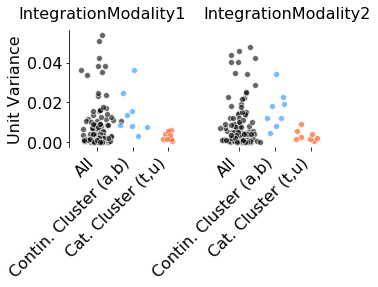

In [51]:
keys = {}
keys[0] = ['delaydm1','delaydm2']
keys[1] = ['delay2','delay2']

epoch_name_ax1, rule_name_ax1, _, _ = take_names(keys[1][0],keys[0][0])
epoch_name_ax2, rule_name_ax2, _, _ = take_names(keys[1][1],keys[0][1])

units = {}
units['all'] = np.ones(n_units)
units['contin'] = np.zeros(n_units)
units['cat'] = np.zeros(n_units)

al = .6

for x in cluster_var['lesion_units_list'][1]:
    units['contin'][x] = 1
for x in cluster_var['lesion_units_list'][2]:
    units['contin'][x] = 1

for x in cluster_var['lesion_units_list'][21]:
    units['cat'][x] = 1
for x in cluster_var['lesion_units_list'][20]:
    units['cat'][x] = 1

fig = plt.figure(figsize=(5,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for key_ind in range(len(keys[0])):
    
    trial = gen_trials_from_model_dir(m,keys[0][key_ind],noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    filename,_ = get_filename(trial,keys[1][key_ind],inds_use[0])

    f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',keys[0][key_ind],filename+'.npz')
    fp_struct = np.load(f)

    fp_use = fp_struct['qstar']<1e-5
    X_test = fp_struct['xstar'][fp_use,:].T

    var = np.var(X_test[units['all']==1,:],axis = 1)
    plt.plot(key_ind*2+npr.randn(len(var))/10,var,'o',color = 'k', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['contin']==1,:],axis = 1)
    plt.plot(.5+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'dodgerblue', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['cat']==1,:],axis = 1)
    plt.plot(1+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'orangered', alpha = al,markeredgecolor = 'w')

plt.ylabel('Unit Variance')
plt.xticks([0*2,0*2+.5,0*2+1,1*2,1*2+.5,1*2+1])
ax.set_xticklabels(['All','Contin. Cluster (a,b)','Cat. Cluster (t,u)',
                    'All','Contin. Cluster (a,b)','Cat. Cluster (t,u)'],rotation = 45,ha = 'right')

# plt.legend(bbox_to_anchor=(1, 2.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.text(0*2-1.1,ax.get_ylim()[1]*1.1,rule_name_ax1)
plt.text(1*2-.5,ax.get_ylim()[1]*1.1,rule_name_ax2)
        
plt.savefig(os.path.join(figpath,'in_out_'+rule_name_ax1+'_'+rule_name_ax2+'.pdf'),bbox_inches='tight')
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

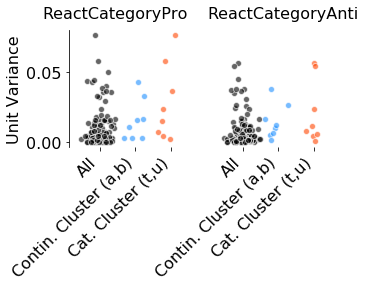

In [52]:
from tools_lnd import take_names
keys = {}
keys[0] = ['dmcgo','dmcnogo']
keys[1] = ['delay1','delay1']
epoch_name_ax1, rule_name_ax1, _, _ = take_names(keys[1][0],keys[0][0])
epoch_name_ax2, rule_name_ax2, _, _ = take_names(keys[1][1],keys[0][1])

units = {}
units['all'] = np.ones(n_units)
units['contin'] = np.zeros(n_units)
units['cat'] = np.zeros(n_units)

al = .6

for x in cluster_var['lesion_units_list'][1]:
    units['contin'][x] = 1
for x in cluster_var['lesion_units_list'][2]:
    units['contin'][x] = 1

for x in cluster_var['lesion_units_list'][21]:
    units['cat'][x] = 1
for x in cluster_var['lesion_units_list'][20]:
    units['cat'][x] = 1

fig = plt.figure(figsize=(5,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for key_ind in range(len(keys[0])):
    
    trial = gen_trials_from_model_dir(m,keys[0][key_ind],noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    filename,_ = get_filename(trial,keys[1][key_ind],inds_use[0])

    f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',keys[0][key_ind],filename+'.npz')
    fp_struct = np.load(f)

    fp_use = fp_struct['qstar']<1e-5
    X_test = fp_struct['xstar'][fp_use,:].T

    var = np.var(X_test[units['all']==1,:],axis = 1)
    plt.plot(key_ind*2+npr.randn(len(var))/10,var,'o',color = 'k', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['contin']==1,:],axis = 1)
    plt.plot(.5+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'dodgerblue', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['cat']==1,:],axis = 1)
    plt.plot(1+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'orangered', alpha = al,markeredgecolor = 'w')

plt.ylabel('Unit Variance')
plt.xticks([0*2,0*2+.5,0*2+1,1*2,1*2+.5,1*2+1])
ax.set_xticklabels(['All','Contin. Cluster (a,b)','Cat. Cluster (t,u)',
                    'All','Contin. Cluster (a,b)','Cat. Cluster (t,u)'],rotation = 45,ha = 'right')

# plt.legend(bbox_to_anchor=(1, 2.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.text(-.8,ax.get_ylim()[1]*1.1,rule_name_ax1)
plt.text(1.5,ax.get_ylim()[1]*1.1,rule_name_ax2)
        
plt.savefig(os.path.join(figpath,'in_out_'+rule_name_ax1+'_'+rule_name_ax2+'.pdf'),bbox_inches='tight')
plt.show()

In [143]:
trial = gen_trials_from_model_dir(m,keys[0][key_ind],noise_on = False)
inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
for ti in range(0,80,5):
        filename,_ = get_filename(trial,keys[1][key_ind],inds_use[ti])
        print(filename)
        
        f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',keys[0][1],filename+'.npz')
        fp_struct = np.load(f)

        fp_use = fp_struct['qstar']<1e-8
        print(np.sum(fp_use))

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
stim1_trial0_x0_y180
1
stim1_trial5_x18_y197
1
stim1_trial10_x45_y

In [145]:
trial.x

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
stim1_trial0_x0_y0
stim1_trial5_x18_y18
stim1_trial10_x45_y45
stim

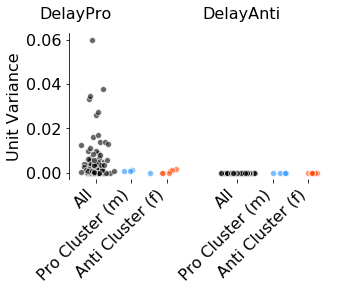

In [146]:
from tools_lnd import take_names
keys = {}
keys[0] = ['fdgo','fdanti']
keys[1] = ['stim1','stim1']
epoch_name_ax1, rule_name_ax1, _, _ = take_names(keys[1][0],keys[0][0])
epoch_name_ax2, rule_name_ax2, _, _ = take_names(keys[1][1],keys[0][1])

units = {}
units['all'] = np.ones(n_units)
units['anti'] = np.zeros(n_units)
units['pro'] = np.zeros(n_units)

al = .6

for x in cluster_var['lesion_units_list'][6]:
    units['anti'][x] = 1

for x in cluster_var['lesion_units_list'][13]:
    units['pro'][x] = 1

fig = plt.figure(figsize=(5,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)


for key_ind in range(len(keys[0])):
    
    X_test = []
    trial = gen_trials_from_model_dir(m,keys[0][key_ind],noise_on = False)
    inds_use = np.where(np.min(trial.stim_strength,axis=1)>.5)[0]
    
    for ti in range(0,80,5):
        
        filename,_ = get_filename(trial,keys[1][key_ind],inds_use[ti])

        f = os.path.join(m,'tf_fixed_pts_manytrials','reviews',keys[0][key_ind],filename+'.npz')
        print(filename)
        fp_struct = np.load(f)

        fp_use = fp_struct['qstar']<1e-8
        
        if ti==0:
            X_test = fp_struct['xstar'][fp_use,:].T
        else:
            np.concatenate((X_test,fp_struct['xstar'][fp_use,:].T),axis =1)

    print(np.shape(X_test))
    var = np.var(X_test[units['all']==1,:],axis = 1)
    plt.plot(key_ind*2+npr.randn(len(var))/10,var,'o',color = 'k', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['pro']==1,:],axis = 1)
    plt.plot(.5+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'dodgerblue', alpha = al,markeredgecolor = 'w')

    var = np.var(X_test[units['anti']==1,:],axis = 1)
    plt.plot(1+key_ind*2+npr.randn(len(var))/10,var,'o',color = 'orangered', alpha = al,markeredgecolor = 'w')

plt.ylabel('Unit Variance')
plt.xticks([0*2,0*2+.5,0*2+1,1*2,1*2+.5,1*2+1])
ax.set_xticklabels(['All','Pro Cluster (m)','Anti Cluster (f)',
                    'All','Pro Cluster (m)','Anti Cluster (f)'],rotation = 45,ha = 'right')

# plt.legend(bbox_to_anchor=(1, 2.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.text(-.8,ax.get_ylim()[1]*1.1,rule_name_ax1)
plt.text(1.5,ax.get_ylim()[1]*1.1,rule_name_ax2)
        
plt.savefig(os.path.join(figpath,'in_out_'+rule_name_ax1+'_'+rule_name_ax2+'.pdf'),bbox_inches='tight')
plt.show()

In [126]:
np.where(var_all>.1)[0]

array([ 6, 10, 33, 38])

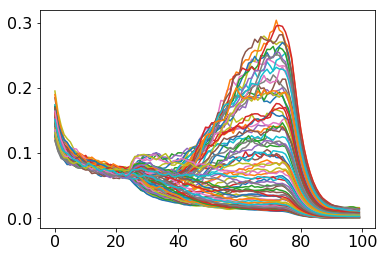

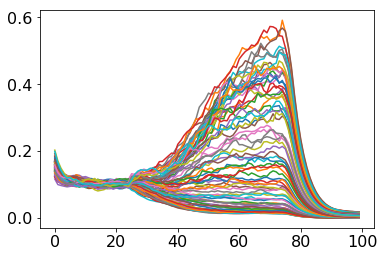

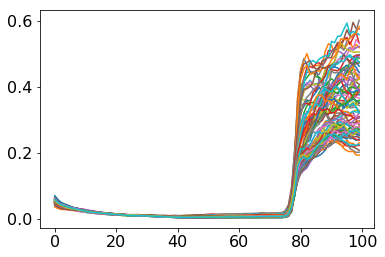

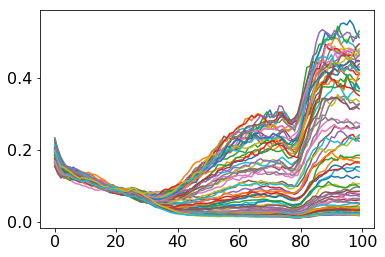

In [129]:
for x in np.where(var_all>.1)[0]:

    plt.plot(h_all_byrule['fdanti'][:,:,x])
    plt.show()

In [105]:
var_all = np.var(X_test[units['all']==1,:],axis = 1)

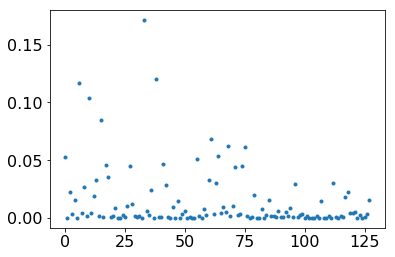

In [107]:
plt.plot(var_all,'.')

In [109]:
np.where(var_all>.1)

(array([ 6, 10, 33, 38]),)

In [115]:
cluster_var['lesion_units_list']

array([None, array([ 71,  26, 127,   6]), array([47, 50, 68, 96]),
       array([ 52,  60,  69, 117,  11]),
       array([ 42,  64,  70,  75, 112,  15,   3]),
       array([ 95,  93,  82, 100,   1,  21,  17]),
       array([ 90, 103,  77,  39,  35,  49]), array([122,  78,  58]),
       array([ 87, 109]), array([ 89,  88, 123,  54]),
       array([ 99, 108, 106,  27,  59]), array([ 80, 114,  53]),
       array([ 79, 125, 118, 107,  18]), array([92, 22, 44, 65]),
       array([113,  40]), array([97, 46, 37, 32]),
       array([ 83,  81, 105,  56]),
       array([  5, 124, 120, 110,  36,  33,  24,  16]),
       array([ 23, 102, 116, 111,  28,  25,  74,  57]),
       array([  4,  91,  86, 101,   2, 115,   7,  31,  29,  34,  72,   8,  10,
        12,  13,  14]),
       array([43, 30, 48, 51]), array([98, 19, 73, 62]),
       array([ 94, 119, 104,  45,   9,  67, 126,  63]),
       array([38, 41, 66]), array([55]), array([85, 84, 76]),
       array([  0,  61, 121,  20])], dtype=object)

In [100]:
rule = 'fdanti'
epoch = 'stim1'

In [101]:
from tools_lnd import make_FP_axs
D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

In [102]:
np.shape(D_use)

(128, 3)

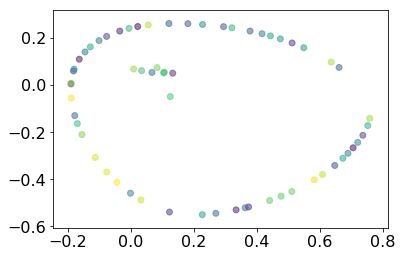

In [103]:
D_h = np.dot(D_use.T,X_test)

plt.scatter(D_h[0,:],D_h[1,:],c = range(np.shape(X_test)[1]),alpha = .5)
plt.show()

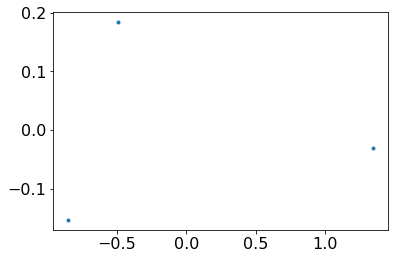

In [124]:
plt.plot(fp_pca[:,0],fp_pca[:,1],'.')

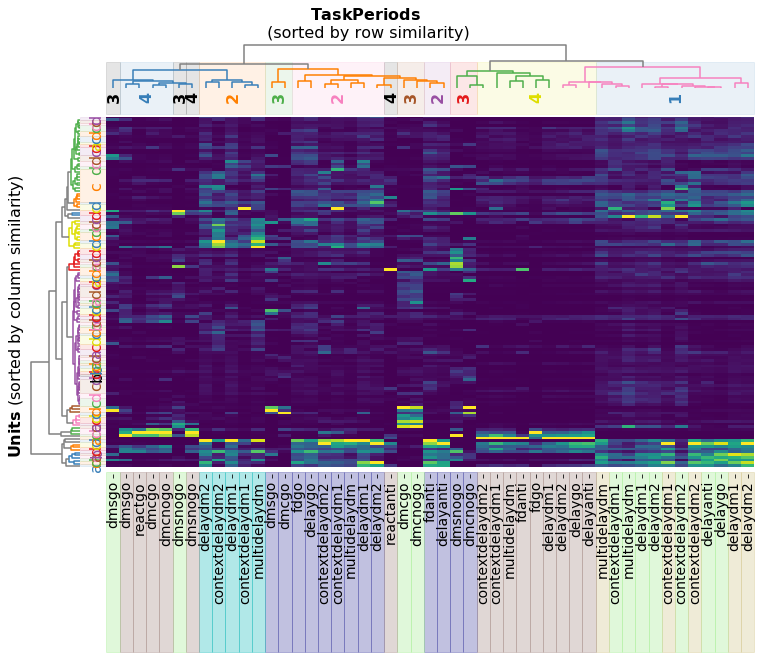

In [48]:
### load master network and make average correlation matrix across seeds

x_ind_counter = 0
ax1_xticks = []

import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
criterion = 'distance'
cel_max_d = '3.5'

m_master = m
lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

D = fp_atlas.T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]

#visualize atlas for master network
fig = plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .55
atlas_height = .55
thresh = 4

axdendro_top = fig.add_axes([.06,atlas_height+.09,atlas_width-.05,.07])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion=criterion)
Z_top = sch.dendrogram(Y, orientation='top',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)
#                     plt.text(-96,-18,'Task Period \n Cluster #')

cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
for xi in range(len(mid_top)-1):
    if cluster_size[xi]==1:
        c = 'k'
    else:
        color_ind = xi - np.sum(cluster_size[:xi]==1)
        c = color_palette[color_ind%len(color_palette)]
    clust_mid = mid_top[xi]
    rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10, 
    fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(clust_mid*10,-3,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)
#                         plt.text(xi*10,-15,str(clusters_sorted[int(xi)]))

remove_spines(axdendro_top)
remove_ticks(axdendro_top)
axdendro_top.set_xticks([])

axdendro = fig.add_axes([0,.054,0.04,atlas_height*.98])
Y = sch.linkage(X, method=method)
clusters = fcluster(Y, max_d, criterion=criterion)

Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=2.07,
                          above_threshold_color='gray', labels = clusters)

# clusters = cluster_var['clusters']
#                     Z = cluster_var['Z']

cluster_size, mid = make_cluster_midpoint_labels(clusters)
for xi in range(len(mid)-1):

    if xi>22:
        ci = xi-1
    else:
        ci = xi

    c = color_palette[ci%len(color_palette)]

    if xi==22:
        c = 'k'

    clust_mid = mid[xi]
    rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(-1.5,10*clust_mid-20,alphabet[clusters[int(clust_mid)]],color =c,rotation = 90)

remove_spines(axdendro)
remove_ticks(axdendro)
axdendro.set_xticks([])


axmatrix = fig.add_axes([.06,0.045,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')

len_te = len(feature_names_labels)
axmatrix.set_xticks(range(len_te))
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
#                     plot_epoch_labels(axmatrix,epoch_binary,which_axes = 'y',ms = 12.5)
plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 65)
#                     plt.legend(bbox_to_anchor=(1.1, -.13),ncol=2,fontsize = 14,rotation = 90)    

plt.text(-8,len(X)/5,r"$\bf{Units}$"+' (sorted by column similarity)',rotation = 90)
# plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master.split()),rotation = 90)
axmatrix.set_xlabel(r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
axmatrix.xaxis.set_label_coords(.4, 1.31)
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((len(X)+1,0))

# make subpanels.
sp_width = .14
sp_wide = .2
offset = .06

plt.show()

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components = len(sorted_fps_dict['dmsnogo']))
fp_pca = pca.fit_transform(sorted_fps_dict['dmsnogo'])
D_use = pca.components_.T

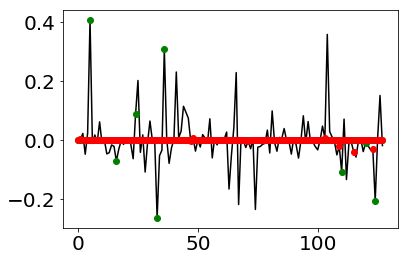

In [61]:
# clust_inds = np.concatenate((cluster_var['lesion_units_list'][1],
#                              cluster_var['lesion_units_list'][2]))#,
# #                              #cluster_var['lesion_units_list'][4]))
    
clust_inds = cluster_var['lesion_units_list'][17]

pca_comp_in = np.zeros(np.shape(pca.components_))
pca_comp_out = np.zeros(np.shape(pca.components_))

pca_comp_in[:,clust_inds] = pca.components_[:,clust_inds]

out_other_inds = [x for i,x in enumerate(range(len(clusters))) if (x!=clust_inds).all()]
out_inds = npr.permutation(out_other_inds)[:len(clust_inds)]
pca_comp_out[:,out_inds] = pca.components_[:,out_inds]

plt.plot(pca.components_[0,:],'-k')
plt.plot(pca_comp_in[0,:],'og')
plt.plot(pca_comp_out[0,:],'or')

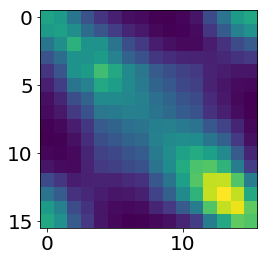

In [62]:
plt.imshow(np.dot(sorted_fps_dict['dmsnogo'],sorted_fps_dict['dmsnogo'].T))

In [63]:
import numpy.linalg as LA

cluster_ones = np.zeros((len(cluster_var['lesion_units_list']),np.shape(sorted_fps_dict[rule])[1]))
for x in range(1,len(cluster_var['lesion_units_list'])):
    cluster_ones[x,cluster_var['lesion_units_list'][x]] = 1
    cluster_ones[[x],:] = cluster_ones[[x],:]/LA.norm(cluster_ones[[x],:])
    
all_ones = np.ones((1,np.shape(sorted_fps_dict[rule])[1]))
all_ones = all_ones/LA.norm(all_ones)

In [67]:
sorted_fps_dict[rule]

array([[0.00294372, 0.08247758, 0.05886957, ..., 0.04552502, 0.07087415,
        0.05927907],
       [0.00044043, 0.01906   , 0.0919157 , ..., 0.03788254, 0.00516265,
        0.27437174],
       [0.00051342, 0.02440043, 0.12571988, ..., 0.03257602, 0.0090502 ,
        0.21717164],
       ...,
       [0.00108976, 0.03662652, 0.16033699, ..., 0.02807232, 0.01994749,
        0.14986292],
       [0.00175634, 0.05089293, 0.17908332, ..., 0.02632849, 0.03249313,
        0.11188903],
       [0.00323097, 0.02393666, 0.01314564, ..., 0.0552844 , 0.02407072,
        0.1505668 ]], dtype=float32)

AttributeError: 'list' object has no attribute 'shape'

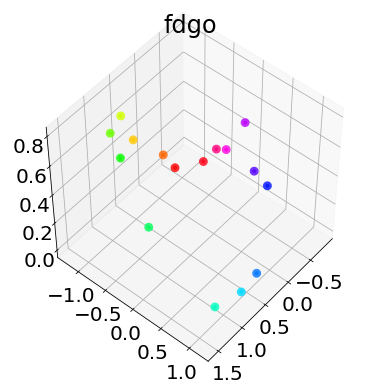

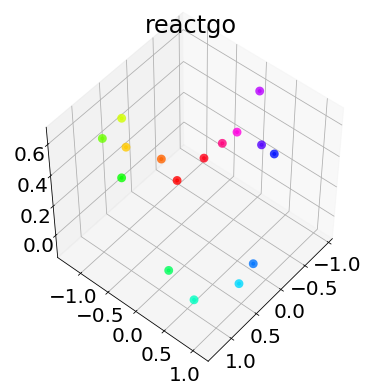

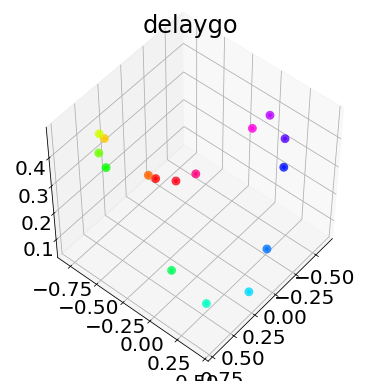

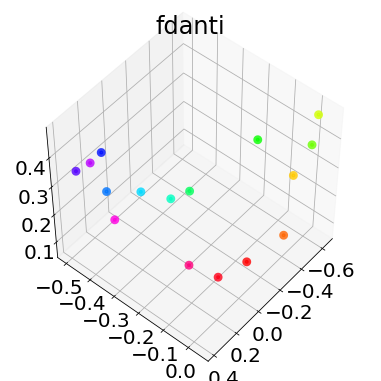

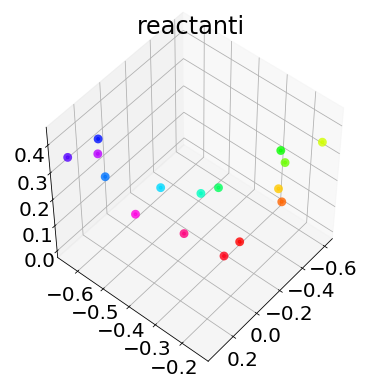

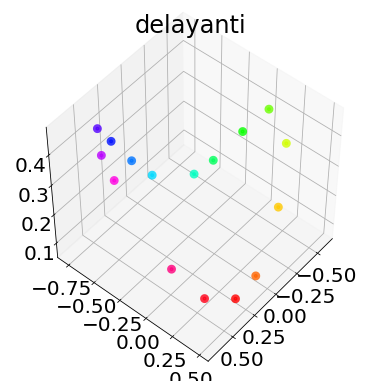

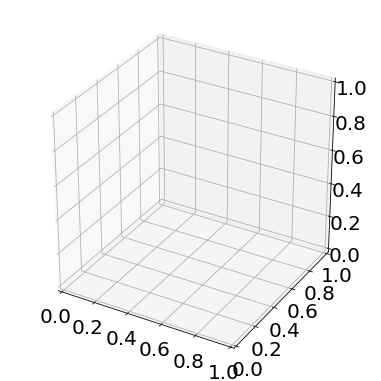

In [64]:

projection_dims = pca.components_#cluster_ones[[1,2,3],:]

var_fp_in_clust = {}

for rule in rule_trains:
    
    var_fp_in_clust[rule] = np.zeros((len(cluster_var['lesion_units_list'])))
    
    for x in range(len(cluster_var['lesion_units_list'])):
        
        AuT = np.dot(sorted_fps_dict[rule],cluster_ones[[x,],:].T)
        uA = np.dot(cluster_ones[[x,],:],sorted_fps_dict[rule].T) 
        trace_ATA = np.trace(np.dot(sorted_fps_dict[rule],sorted_fps_dict[rule].T))
        uAAu_trace_ATA = np.dot(uA,AuT)/trace_ATA

        var_fp_in_clust[rule][x] = uAAu_trace_ATA# np.var(np.dot(sorted_fps_dict[rule],cluster_ones[x,:].T))/np.var(np.dot(sorted_fps_dict[rule],all_ones.T))

    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1], projection='3d');
    
    fp_project = np.dot(sorted_fps_dict[rule],projection_dims.T)
    ax.scatter(fp_project[:,0],fp_project[:,1],fp_project[:,2],
               s = 10*1.5,
               marker = 'o',
               c = range(16),
               alpha = .8,
               linewidth = 5,
              cmap = 'hsv')

    ax.view_init(50, 40)
    plt.title(rule)#+' : '+str(var_fp_in_clust[rule]))
#     ax.axes.set_xlim3d(left=-2, right=2) 
#     ax.axes.set_ylim3d(bottom=-2, top=2) 
#     ax.axes.set_zlim3d(bottom=-2, top=2) 

plt.show()

KeyError: 'fdgo'

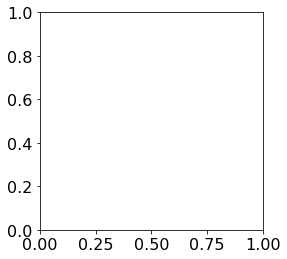

In [54]:
for x in range(1,len(cluster_var['lesion_units_list'])):
    

    fig = plt.figure(figsize=(4,4))
    ax = plt.subplot(111)

    for rule_i in range(len(rule_trains)):
        rule = rule_trains[rule_i]

        plt.plot(rule_i,var_fp_in_clust[rule][x],'o')

    ax.set_xticks(range(len(rule_trains)))
    ax.set_xticklabels(rule_trains,rotation = 90, horizontalalignment = 'center')
    plt.ylim([0,.2])
    
    plt.title(alphabet[x])

In [55]:
var_in = np.var(np.dot(pca_comp_in,X),axis = 1)
var_out = np.var(np.dot(pca_comp_out,X),axis = 1)

NameError: name 'pca_comp_in' is not defined

In [56]:
fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')


for rep in range(100):
    
    out_inds = npr.permutation(np.where(clusters!=cluster_ind)[0])[:len(np.where(clusters==cluster_ind)[0])]
    out_other_inds = [x for i,x in enumerate(range(len(clusters))) if (x!=out_inds).all()]
    pca_comp_out[:,:] = pca.components_
    pca_comp_out[:,out_other_inds] = 0
    var_out = np.var(np.dot(pca_comp_out,X),axis = 1)

    plt.plot(np.cumsum(var_out),'gray',alpha = .4)
    
plt.plot(np.cumsum(var_in),linewidth= 2)

NameError: name 'cluster_ind' is not defined

<Figure size 360x360 with 0 Axes>

In [57]:
plt.plot(abs(pca.components_.T[:,0]),X[:,46],'.')

NameError: name 'pca' is not defined

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

/usr/local/Caskroom/miniconda/base/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


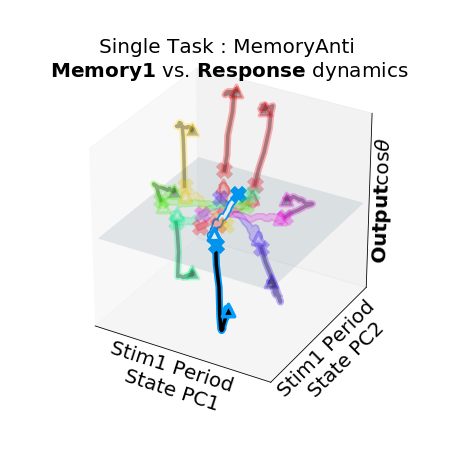

In [58]:
from task import generate_trials, rule_name, rule_index_map, rules_dict
rule_set = [5,5]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]

epoch_set = ['stim1','stim1']

rule_axs = 0
epoch = epoch_set[rule_axs]
ti = trial_num[rule_axs]


D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = D_use[:,0]
D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' Period \n State PC1',
             epoch_name_ax+' Period \n State PC2',
             epoch_name_ax+' Period \n State PC3']

epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'
interp = False

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = False,fig_size = 6,figpath = figpath,
         ruleset = '2task_interp',alpha_fp = .1, stability_thresh = 2, ax_labels = ax_labels)